In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from transformers import GPT2Model, GPT2Config
import skimage as sk
import random

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)

to_numpy = lambda x: x.detach().cpu().numpy()

cuda:1


Files already downloaded and verified


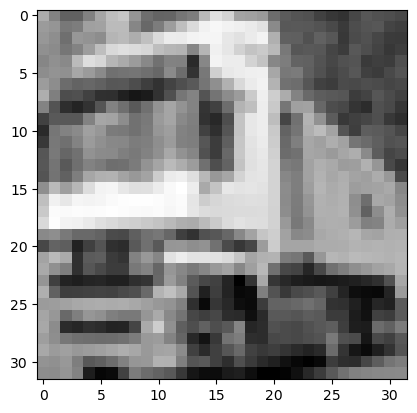

In [2]:
cifar = torchvision.datasets.CIFAR10(download=True, root='.')
cifar = cifar.data.transpose((0, 3, 1 ,2)).mean(1, keepdims=True)
# cifar = (cifar - cifar.mean((0, 2, 3), keepdims=True)) / (cifar.std((0, 2, 3), keepdims=True))
plt.imshow(cifar[1, 0], cmap='gray')

In [3]:
cifar_small = sk.transform.rescale(cifar, 0.5)
cifar_mini = sk.transform.rescale(cifar, 0.25)

(89400, 1, 16, 16)
(89400, 5)
[1. 0. 0. 0. 0.]


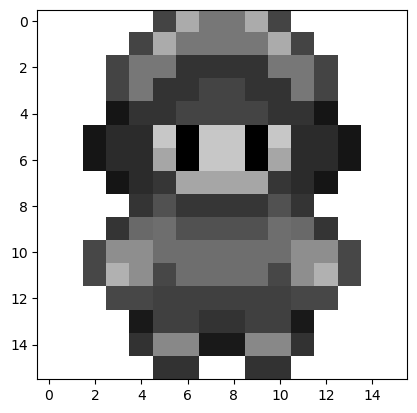

In [4]:
sprites = np.load('sprites.npy')
sprites = np.transpose(sprites, (0, 3, 1, 2)).mean(axis=1, keepdims=True)
sprite_labels = np.load('sprites_labels.npy')
print(sprites.shape)
print(sprite_labels.shape)
plt.imshow(sprites[0, 0], cmap='gray')
print(sprite_labels[0])

In [5]:
class PatchEmbed(nn.Module):
    def __init__(self, image_size=16, patch_size=2, in_chans=1, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.grid_h = image_size // patch_size
        self.grid_w = image_size // patch_size
        self.h_embed = nn.Parameter(torch.randn(1, embed_dim, self.grid_h, 1))
        self.w_embed = nn.Parameter(torch.randn(1, embed_dim, 1, self.grid_w))

    def forward(self, x):
        x = self.proj(x)  # [B, D, H/patch, W/patch]
        x = x + self.h_embed + self.w_embed
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, D]
        return x

In [6]:
class SimpleViT(nn.Module):
    def __init__(self, image_size=16, patch_size=2, embed_dim=256, num_layers=4, nhead=4):
        super().__init__()
        self.patch_embed = PatchEmbed(image_size=image_size, embed_dim=embed_dim, patch_size=patch_size)
        encoder = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder, num_layers=num_layers)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        patches = self.patch_embed(x)  # [B*T, P, D]
        # patches = patches.view(B, T, -1, patches.shape[-1])  # [B, T, P, D]
        # patches = patches.flatten(1, 2)  # [B, T*P, D]
        embeddings = self.transformer(patches)[:, -1, :]
        embeddings = embeddings.view(B, T, -1)
        return embeddings

class MiniResnet(nn.Module):
    def __init__(self, image_size=16, embed_dim=256, num_layers=8):
        super().__init__()
        self.input_conv = nn.Conv2d(1, 32, 3, 1, 1)
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(nn.Conv2d(32, 32, 3, 1, 1))
        self.output = nn.Linear(image_size**2 *32, embed_dim)
    
    def forward(self, x):
        x = F.relu(self.input_conv(x))
        for layer in self.convs:
            x = F.relu(layer(x)) + x
        x = x.flatten(1)
        x = self.output(x)
        return x


In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, image_size=16, embed_dim=1, num_convs=1, num_channels=1, patch_size=2):
        # Let's just do x convs followed by a single linear layer
        super().__init__()
        self.convs = nn.ModuleList()
        for i in range(num_convs):
            # if i == 0:
            self.convs.append(nn.Conv2d(num_channels, num_channels, kernel_size=patch_size, stride=patch_size, bias=False))
            # else:
            #     self.convs.append(nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False))
        self.conv_size = num_channels * (image_size * image_size) // (patch_size * patch_size)
        self.linear = nn.Linear(self.conv_size, embed_dim, bias=False)
        self._initialize_weights()

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)#F.relu(conv(x))
        x = x.flatten(1)
        x = self.linear(x)
        return x
    
    def _initialize_weights(self):
        layers = [m for m in self.modules() if isinstance(m, (nn.Linear, nn.Conv2d))]
        for i, m in enumerate(layers):
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                if i < len(layers) - 1:
                    nn.init.normal_(m.weight)
                else:
                    nn.init.normal_(m.weight, std=2/self.conv_size)

class SimpleMLP(nn.Module):
    def __init__(self, image_size=16, embed_dim=1, hidden_dim=100, num_hidden=0):
        super().__init__()
        self.input_size = image_size ** 2
        self.hidden_dim = hidden_dim
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.input_size, hidden_dim, bias=False))
        for _ in range(num_hidden):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim, bias=False))
        self.output_layer = nn.Linear(hidden_dim, embed_dim, bias=False)
        self._initialize_weights()
        
    def forward(self, x):
        x = x.flatten(1)
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.output_layer(x)
        
    def _initialize_weights(self):
        layers = [m for m in self.modules() if isinstance(m, (nn.Linear, nn.Conv2d))]
        for i, m in enumerate(layers):
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                if i < len(layers) - 1:
                    nn.init.normal_(m.weight)
                else:
                    nn.init.normal_(m.weight, std=2/self.hidden_dim)
            

In [8]:
class VisionICLTransformer(nn.Module):
    def __init__(self, val_dim=1, embed_dim=256, num_heads=8, num_layers=12, vit_heads=2, vit_layers=8,
                 image_size=16, patch_size=2, max_seq_len=128):
        # max_seq_len corresponds to 2k, so k x_k samples and k f(x_k), and then one more for x_query
        super().__init__()

        self.grid_h = image_size // patch_size
        self.grid_w = image_size // patch_size
        self.num_patches = self.grid_h * self.grid_w

        self.time_embed = nn.Parameter(torch.randn(1, max_seq_len * 2, embed_dim))

        self.val_dim = val_dim
        self.value_proj = nn.Linear(val_dim, embed_dim)

        self.vit = SimpleViT(image_size, patch_size, embed_dim, vit_layers, vit_heads)
        self.cnn = MiniResnet(image_size, embed_dim=embed_dim)
        # decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        # self.transformer = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        config = GPT2Config(
            n_positions=2 * max_seq_len,
            n_embd=embed_dim,
            n_layer=num_layers,
            n_head=num_heads,
            resid_pdrop=0.0,
            embd_pdrop=0.0,
            attn_pdrop=0.0,
            use_cache=False,
        )
        self.transformer = GPT2Model(config)

        self.fc_out = nn.Linear(embed_dim, val_dim)

    def forward(self, images, values):
        B, T, C, H, W = images.shape
        B, T, _ = values.shape
        # images = images.reshape(-1, *images.shape[2:])
        img_embeddings = self.vit(images) #self.cnn(images)
        # img_embeddings = img_embeddings.reshape(B, T, -1)
        # img_embeddings = self.vit(images)

        inds = torch.arange(T).to(device)

        val_embeds = self.value_proj(values)

        embeddings = self.interleave(img_embeddings, val_embeds)
        # embeddings = embeddings + self.time_embed[:, :2 * T]

        # mask = nn.Transformer.generate_square_subsequent_mask(2 * T).to(embeddings.device)
        # memory = torch.zeros(B, 1, embeddings.shape[-1]).to(embeddings.device)
        # x = self.transformer(tgt=embeddings, memory=memory, tgt_mask=mask) 

        # return self.fc_out(x[:, ::2])
        x = self.transformer(inputs_embeds=embeddings).last_hidden_state
        predictions = self.fc_out(x)

        return predictions[:, ::2, 0][:, inds]
    
    def interleave(self, xs, ys):
        B, T, D = xs.shape
        stacked = torch.stack((xs, ys), dim=2)  # [B, T, 2, D]
        interleaved = stacked.view(B, 2 * T, D)
        return interleaved

Actual Toy Problem

In [9]:
def sample_image_set(image_set, b, n, d=None):
    indices = torch.randint(0, image_set.shape[0], (b * n,))
    images = torch.tensor(image_set[indices].reshape(b, n, *image_set.shape[1:])).float().to(device)
    shape = images.shape
    images = (images - image_set.mean()) / (image_set.std() + 1e-8)
    # images = images.reshape(b, n, 1, -1)
    if d is not None:
        images[:, :, :, d:] = 0
        images[:, :, :, :, d:] = 0
    # images = images.reshape(shape)
    return images

# def sample_sprites(b, n):
#     indices = torch.randint(0, sprites.shape[0], (b, n))
#     images = torch.tensor(sprites[indices]).float().to(device)
#     return images

# def sample_cifar(b, n, d):
#     indices = torch.randint(0, cifar.shape[0], (b, n))
#     images = torch.tensor(cifar[indices]).float().to(device)
#     images[:, :, :, d:] = 0
#     images[:, :, :, :, d:] = 0
#     return images

def sample_noise(b, n, d, d_max=16):
    noise = torch.randn((b, n, 1, d_max, d_max))
    noise[:, :, :, d:] = 0
    noise[:, :, :, :, d:] = 0
    return noise.to(device)

def ensemble_predict(models, images):
    ensemble_size = len(models)
    batch_dim = images.shape[0]
    step = batch_dim // ensemble_size
    ind = 0
    i = 0
    predictions = []
    while ind < batch_dim:
        predictions.append(models[i](images[ind:min(batch_dim, ind+step)]))
        ind += step
        i += 1
        
    return torch.concat(predictions)

def anneal_lr(optim, lr, update, num_updates, transition_step=1000):
    update -= 1
    if update <= transition_step:
        new_lr = lr * (0.5 ** (update / transition_step))
    else:
        frac = 1 - (update - transition_step) / (num_updates - transition_step)
        new_lr = max(0, 0.5 * lr * frac) # max probably unneccesary but better than having a negative
    optim.param_groups[0]["lr"] = new_lr

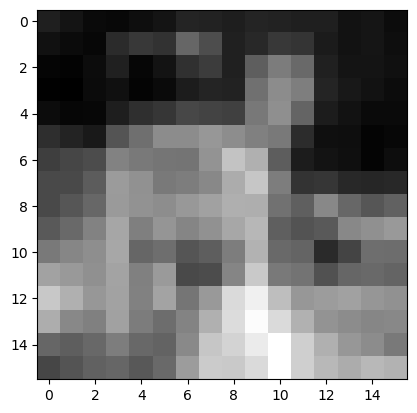

In [10]:
plt.imshow(to_numpy(sample_image_set(cifar_small, 1, 4, 32))[0, 0, 0], cmap='gray')

In [ ]:
total_updates = 300000
increase_after = 5000
b = 64
d = 2
k = 5
n = d * k + 1 # might need to lower this back to 64 for colab
e = b
lr = 1e-4
image_size = 8
stop_on = 0.01
current_i = 0
weighting = ((torch.arange(1, n+1) * 2 / n) ** 2).to(device)
print(weighting)

losses = []
final_losses = []
large_transformer = VisionICLTransformer(image_size=image_size, patch_size=4, vit_layers=4).to(device)
optim = torch.optim.AdamW(large_transformer.parameters(), lr)
for i in range(1, total_updates + 1):
    # anneal_lr(optim, lr, i, total_updates, transition_step=20000)
    if i % 100 == 0:
        print(f'epoch: {i}, {np.mean(losses[-10:])}, {np.mean(final_losses[-10:])}, {f_xquery.norm(dim=-1).mean().item()}, {true_f_xquery.norm(dim=-1).mean().item()}')
    if i - current_i == increase_after:
        if d < image_size:
            d += 1
            n = d * k + 1
            increase_after += 0
            current_i = i
            weighting = ((torch.arange(n) * 2 / n) ** 2).to(device)
            print(f'increasing difficulty to d={d}, n={n}')
        elif np.mean(final_losses[-10:]) < stop_on:
            break
    ws = torch.randn(b, 1, image_size ** 2).to(device)
    images = sample_image_set(cifar_mini, b, n, d)
    # images = sample_noise(b, n, d, image_size)
    temp_images = images.reshape(b, n, image_size ** 2)
    embeddings = (ws * temp_images).sum(-1, keepdim=True)
    true_f_xquery= embeddings = embeddings.reshape(b, n, -1)
    f_xquery = large_transformer(images, embeddings)
    true_f_xquery = true_f_xquery.squeeze(-1)
    loss = (weighting * (f_xquery - true_f_xquery) ** 2).sum(1).mean() # * weighting.view(1, -1)
    final_loss = F.mse_loss(f_xquery[:, -1], true_f_xquery[:, -1])
    final_losses.append(final_loss.item())
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()

tensor([0.0331, 0.1322, 0.2975, 0.5289, 0.8264, 1.1901, 1.6198, 2.1157, 2.6777,
        3.3058, 4.0000], device='cuda:1')
epoch: 100, 96.32614974975586, 5.334938430786133, 1.4549204111099243, 5.4188947677612305
epoch: 200, 41.7387393951416, 1.8457559585571288, 4.192480087280273, 5.838024139404297
epoch: 300, 23.865488815307618, 1.0815931916236878, 4.86646032333374, 7.167288780212402
epoch: 400, 17.329766368865968, 0.9080939948558807, 5.211816787719727, 6.315658092498779
epoch: 500, 15.431550979614258, 0.8110490381717682, 4.708935737609863, 6.192078113555908
epoch: 600, 14.6173565864563, 0.7607537567615509, 5.044563293457031, 6.490026473999023
epoch: 700, 13.310167789459229, 0.7838519513607025, 5.954197406768799, 6.858458042144775
epoch: 800, 13.251320934295654, 0.7026012778282166, 4.944042205810547, 5.657472133636475
epoch: 900, 12.656496810913087, 0.6816964864730835, 5.990180969238281, 6.718340873718262
epoch: 1000, 13.247875118255616, 0.702372995018959, 5.984891891479492, 6.860975265

KeyboardInterrupt: 

In [12]:
ws = torch.randn(b, 1, image_size ** 2).to(device)
images = sample_image_set(cifar_mini, b, n, d-1)
temp_images = images.reshape(b, n, image_size ** 2)
embeddings = (ws * temp_images).sum(-1, keepdim=True)
true_f_xquery = embeddings = embeddings.reshape(b, n, -1)
f_xquery = large_transformer(images, embeddings)
true_f_xquery = true_f_xquery.squeeze(-1)
F.mse_loss(f_xquery[:, -1], true_f_xquery[:, -1])
print(f_xquery[:, -1])
print(true_f_xquery[:, -1])

tensor([  1.2342, -11.1042,  -4.7385,  -2.3757,   4.9131, -19.3614,  -3.7257,
         -2.1100,  -1.8145,  -9.1423,   8.2406,   4.8947,   2.7439,  -0.9780,
         10.7824,  -2.6385,  -2.6735,  -4.4044,  -5.0670, -11.4461,   7.7096,
          0.7026,  -7.0937,   0.5277,   3.7879,  -5.3490,   4.0939, -10.8492,
          6.6343,   3.0693,  -3.1143,  -1.5660,   2.7191,   2.9311,  -8.3996,
          3.3677,  -0.2445, -10.5367,   0.2957,  -8.5856,  -2.8677,  -2.6332,
         -3.1813,   0.9987, -12.2555,  -8.7698,  -6.9228,  -1.6021,   6.6221,
          1.8059,  -1.1848,  -8.1841,  -2.6013, -15.7416,  -1.0459,   2.3120,
         -3.9132,   7.7224,   0.6885,   2.7427,   2.1243,   0.6371,  -6.4195,
          4.4475], device='cuda:1', grad_fn=<SelectBackward0>)
tensor([  0.9421,  -9.8830,  -9.2931,  -2.6111,   3.4027, -19.2340,  -4.7534,
         -4.6584,  -4.2819,  -5.9971,   9.4601,   7.4737,   2.9731,  -1.6179,
          7.9160,  -2.7203,  -3.5525,  -2.5947,  -2.7100, -10.9207,   7.3001,
 

In [13]:
torch.save(large_transformer.state_dict(), 'exp2_model.pt')

In [14]:
images = sample_image_set(cifar_mini, b, n, d)
testcnn = SimpleCNN(image_size).to(device)
embeddings = testcnn(images.reshape(b * n, 1, image_size, image_size))
true_f_xquery = embeddings = embeddings.reshape(b, n, -1)
f_xquery = large_transformer(images, embeddings)
true_f_xquery = true_f_xquery.squeeze(-1)
F.mse_loss(f_xquery[:, -1], true_f_xquery[:, -1])
print(f_xquery[:, -1])
print(true_f_xquery[:, -1])

tensor([ 0.2595,  0.2406,  0.3287,  0.8631,  1.2195, -0.5351,  0.2396,  0.6604,
         0.5947,  0.5976,  0.3002, -0.0381,  1.6087,  0.4176,  0.0141,  0.1388,
         0.1227, -0.7628, -0.8941,  0.3334, -0.1343, -0.7341, -0.3289,  0.2067,
        -0.6328,  0.8645, -0.3650, -0.3546,  0.2765,  0.1796, -0.6521, -0.3231,
        -0.3003, -1.0140, -0.0032,  0.1807, -0.2691,  0.7067, -0.2126,  0.6567,
        -0.3310, -0.0617, -0.9899, -0.8842, -1.1065,  0.1683,  0.2768,  0.3364,
         0.1588,  0.7361, -0.0994,  0.0749, -0.4990, -1.2278,  0.4762,  0.1221,
         0.0073,  0.2412, -0.7210,  0.1947,  0.1210, -0.2599,  0.2843, -0.2365],
       device='cuda:1', grad_fn=<SelectBackward0>)
tensor([ 0.3732,  0.7515,  0.2403,  0.1507,  0.7867, -0.8053,  0.5631,  0.0430,
         0.4177,  0.6527,  1.2186, -0.1794,  1.2943,  0.9672, -0.2126,  0.0707,
         0.7187, -1.2592, -0.8896,  0.9228, -1.0978, -0.9669, -1.1336,  0.4871,
        -0.3071,  0.7602,  0.1718,  0.4284,  0.4447, -0.1578, -0.108

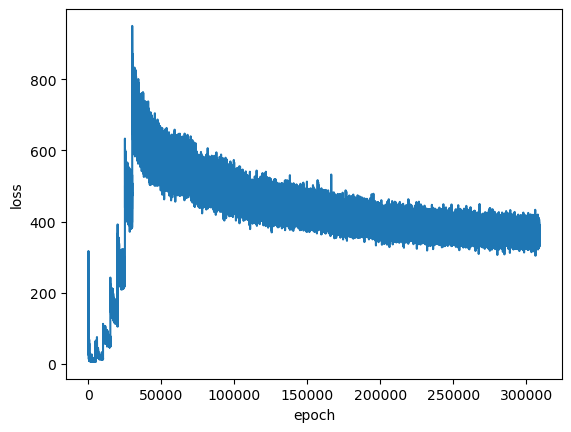

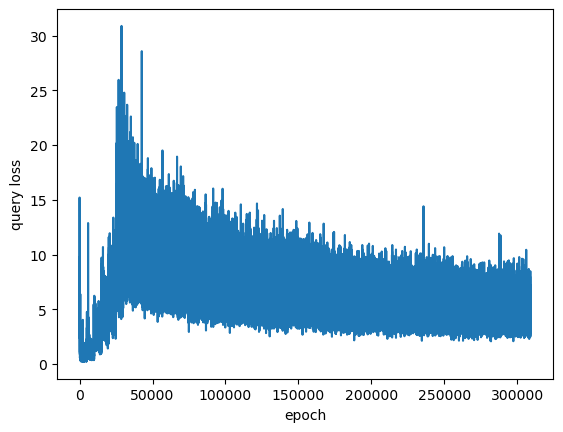

In [15]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('exp2_loss.png')
plt.show()
plt.plot(final_losses)
plt.xlabel('epoch')
plt.ylabel('query loss')
plt.savefig('exp2_query_loss.png')